# Bank's Credit Card Service Churn Prediction

### Importing the libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Split the data.
from sklearn.model_selection import train_test_split

# Utils
# from ..src.utils.eda_utils import analysis_plot

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

### Utils

In [24]:
def analysis_plots(data, features, histplot=True, barplot=False, mean=None, text_y=0.5,    
                   outliers=False, boxplot=False, boxplot_x=None, kde=False, hue=None, 
                   nominal=False, color='#023047', figsize=(24, 12)):
    # Get num_features and num_rows and iterating over the sublot dimensions.
    num_features = len(features)
    num_rows = num_features // 3 + (num_features % 3 > 0) 
    
    fig, axes = plt.subplots(num_rows, 3, figsize=figsize)  

    for i, feature in enumerate(features):
        row = i // 3  
        col = i % 3  

        ax = axes[row, col] if num_rows > 1 else axes[col] 
        
        if barplot:
            if mean:
                data_grouped = data.groupby([feature])[[mean]].mean().reset_index()
                data_grouped[mean] = round(data_grouped[mean], 2)
                ax.barh(y=data_grouped[feature], width=data_grouped[mean], color=color)
                for index, value in enumerate(data_grouped[mean]):
                    # Adjust the text position based on the width of the bars
                    ax.text(value + text_y, index, f'{value:.1f}', va='center', fontsize=15)
            else:
                if hue:
                    data_grouped = data.groupby([feature])[[hue]].mean().reset_index().rename(columns={hue: 'pct'})
                    data_grouped['pct'] *= 100
                else:
                    data_grouped = data.groupby([feature])[[feature]].count().rename(columns={feature: 'count'}).reset_index()
                    data_grouped['pct'] = data_grouped['count'] / data_grouped['count'].sum() * 100
    
                ax.barh(y=data_grouped[feature], width=data_grouped['pct'], color=color)
                
                if pd.api.types.is_numeric_dtype(data_grouped[feature]):
                    ax.invert_yaxis()
                    
                for index, value in enumerate(data_grouped['pct']):
                    # Adjust the text position based on the width of the bars
                    ax.text(value + text_y, index, f'{value:.1f}%', va='center', fontsize=15)
            
            ax.set_yticks(ticks=range(data_grouped[feature].nunique()), labels=data_grouped[feature].tolist(), fontsize=15)
            ax.get_xaxis().set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.grid(False)
    
        elif outliers:
            # Plot univariate boxplot.
            sns.boxplot(data=data, x=feature, ax=ax, color=color)
        
        elif boxplot:
            # Plot multivariate boxplot.
            sns.boxplot(data=data, x=boxplot_x, y=feature, showfliers=outliers, ax=ax, palette=palette)

        else:
            # Plot histplot.
            sns.histplot(data=data, x=feature, kde=kde, ax=ax, color=color, stat='proportion', hue=hue)

        ax.set_title(feature)  
        ax.set_xlabel('')  
    
    # Remove unused axes.
    if num_features < len(axes.flat):
        for j in range(num_features, len(axes.flat)):
            fig.delaxes(axes.flat[j])

    plt.tight_layout()

In [26]:
def check_outliers(data, features):
    
    outlier_counts = {}
    outlier_indexes = {}
    total_outliers = 0
    
    for feature in features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        feature_outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
        outlier_indexes[feature] = feature_outliers.index.tolist()
        outlier_count = len(feature_outliers)
        outlier_counts[feature] = outlier_count
        total_outliers += outlier_count
    
    print(f'There are {total_outliers} outliers in the dataset.')
    print()
    print(f'Number (percentage) of outliers per feature: ')
    print()
    for feature, count in outlier_counts.items():
        print(f'{feature}: {count} ({round(count/len(data)*100, 2)})%')

    return outlier_indexes, outlier_counts, total_outliers

# 2. Understanding the data
- The dataset was collected from kaggle: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers?sort=votes
- The dataset origin is from this site: https://leaps.analyttica.com/home
- It contains credit card customers data, with demographic, financial and product information. It is already labeled, with churners identified as 1 and non-churners identified as 0 in the attrition flag variable.
- I will initially drop two variables because I don't have access to what they mean, and they seem to be results of a Naive Bayes machine learning model.

In [3]:
data_path = '../data/input/BankChurners.csv'
df = pd.read_csv(data_path)

# Features that must be dropped.
df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'], inplace=True)

In [4]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [6]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset has 10127 rows and 21 columns.


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CLIENTNUM,10127.0,7.391776e+08,3.690378e+07,708082083.0,7.130368e+08,7.179264e+08,7.731435e+08,8.283431e+08
Customer_Age,10127.0,4.632596e+01,8.016814e+00,26.0,4.100000e+01,4.600000e+01,5.200000e+01,7.300000e+01
Dependent_count,10127.0,2.346203e+00,1.298908e+00,0.0,1.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00
Months_on_book,10127.0,3.592841e+01,7.986416e+00,13.0,3.100000e+01,3.600000e+01,4.000000e+01,5.600000e+01
Total_Relationship_Count,10127.0,3.812580e+00,1.554408e+00,1.0,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00
Months_Inactive_12_mon,10127.0,2.341167e+00,1.010622e+00,0.0,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
Contacts_Count_12_mon,10127.0,2.455317e+00,1.106225e+00,0.0,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
Credit_Limit,10127.0,8.631954e+03,9.088777e+03,1438.3,2.555000e+03,4.549000e+03,1.106750e+04,3.451600e+04
Total_Revolving_Bal,10127.0,1.162814e+03,8.149873e+02,0.0,3.590000e+02,1.276000e+03,1.784000e+03,2.517000e+03
Avg_Open_To_Buy,10127.0,7.469140e+03,9.090685e+03,3.0,1.324500e+03,3.474000e+03,9.859000e+03,3.451600e+04


Some insights:
1. The average age is approximately 46 years. Half the customers are from 41 to 52 years old, indicating an older profile.
2. On average, customers held approximately 4 products of the bank.
2. 75% of the customers spent at least 2 months inactive in the last 12 months. This is a bad indicator. The bank must plan strategies to improve its clients consumption.
3. 75% of the customers contacted the bank at least 2 times in the last 12 months. This is also bad, something in the credit card product is leading customers to contact the company, probably unsatisfied.
2. The average credit limit is 8,632. Moreover, it seems to be skewed to the right (mean is greater than median, minimum credit limit is 1,438, while maximum is 34,516).
4. The average utilization ratio is about 28%. This is a low value. Moreover, half the customers present a utilization ratio up to 17.6%. The bank must pay attention to it and try to increase the utilization of its credit card service.
5. On average, customers made approximately 65 transactions in the last 12 months. This indicates that customers made about 5.4 transactions per month in a year, which is very low.
6. Moreover, observing the minimum and maximum values, seems there are no inconsistent values.

Looking at missing ad duplicated values.

In [9]:
df.isna().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [10]:
df.duplicated().sum()

np.int64(0)

No Missing Values found in data

- Drop `CLIENTNUM` variable for analysis since it has all unique values. No insights provided
- Rename Columns in standard format for easier data manipulation.
- Express `Gender` and `Attrition_Flag` as binary variables for easier representation.

In [11]:
df.drop(columns=['CLIENTNUM'], inplace=True)

df.columns = [x.lower() for x in df.columns]

df['gender'] = df['gender'].map({'M': 1, 'F': 0})
df['attrition_flag'] = df['attrition_flag'].map({'Attrited Customer': 1, 'Existing Customer': 0})

df.rename(columns={'attrition_flag': 'churn_flag'}, inplace=True)

# 3. Split the data into train and test sets
- Split Data into Train and Test sets.
- Perform EDA on training set to avoid data leakage, and evaluate model with unseen data
- Perform Startified Split for Train and Test sets to maintain same percentage of target class
This is particularly useful when dealing with imbalanced datasets, which is the case, as there are more existing customers than attrited ones.

In [12]:
X = df.drop(columns=['churn_flag'])
y = df['churn_flag'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [13]:
print(f'Train predictor dataset shape: {X_train.shape}.')
print(f'Train target dataset shape: {y_train.shape}.')
print(f'Test predictor dataset shape: {X_test.shape}.')
print(f'Test target dataset shape: {y_test.shape}.')

Train predictor dataset shape: (8101, 19).
Train target dataset shape: (8101,).
Test predictor dataset shape: (2026, 19).
Test target dataset shape: (2026,).


In [14]:
print(f'Train target proportion: ')
print(f'{y_train.value_counts(normalize=True)}')
print(f'\nTest target proportion: ')
print(f'{y_test.value_counts(normalize=True)}')

Train target proportion: 
churn_flag
0    0.839279
1    0.160721
Name: proportion, dtype: float64

Test target proportion: 
churn_flag
0    0.839585
1    0.160415
Name: proportion, dtype: float64


# 4. Exploratory data analysis

In [16]:
train = pd.concat([X_train, y_train], axis=1)
train.head()

,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,churn_flag
2856,36,0,0,Unknown,Married,Less than $40K,Blue,24,4,3,2,2570.0,2230,340.0,0.686,1755,42,0.448,0.868,0
6515,44,1,3,High School,Single,$60K - $80K,Silver,36,5,2,3,25276.0,0,25276.0,0.849,2282,38,0.583,0.000,1
7141,46,1,2,High School,Married,$80K - $120K,Blue,30,6,3,1,11670.0,915,10755.0,0.892,4277,89,0.854,0.078,0
632,36,0,2,Graduate,Married,Less than $40K,Blue,24,3,1,3,3124.0,1593,1531.0,0.869,1652,41,0.367,0.510,0
3496,50,1,1,Graduate,Single,$120K +,Blue,40,4,2,3,34516.0,1185,33331.0,0.725,3874,72,0.714,0.034,0


In [17]:
numerical_features = X_train.select_dtypes('number').columns.tolist()
categorical_features = X_train.select_dtypes('object').columns.tolist()
target = 'churn_flag'

print(f'There are {len(numerical_features)} numerical features. They are: ')
print(numerical_features)
print(f'\nThere are {len(categorical_features)} categorical features. They are: ')
print(categorical_features)
print(f'\nThe target feature is: {target}.')

There are 15 numerical features. They are: 
['customer_age', 'gender', 'dependent_count', 'months_on_book', 'total_relationship_count', 'months_inactive_12_mon', 'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal', 'avg_open_to_buy', 'total_amt_chng_q4_q1', 'total_trans_amt', 'total_trans_ct', 'total_ct_chng_q4_q1', 'avg_utilization_ratio']

There are 4 categorical features. They are: 
['education_level', 'marital_status', 'income_category', 'card_category']

The target feature is: churn_flag.


Check for Cardinality of Categorical Features before choosing encoding techniques

In [18]:
for feature in categorical_features:
    print(feature)
    print('-'*40)
    print(f'There are {train[feature].nunique()} unique values. They are: ')
    print(train[feature].value_counts(normalize=True))
    print()

education_level
----------------------------------------
There are 7 unique values. They are: 
education_level
Graduate         0.306382
High School      0.203679
Unknown          0.148994
Uneducated       0.146031
College          0.098259
Post-Graduate    0.052710
Doctorate        0.043945
Name: proportion, dtype: float64

marital_status
----------------------------------------
There are 4 unique values. They are: 
marital_status
Married     0.463523
Single      0.387853
Unknown     0.074682
Divorced    0.073941
Name: proportion, dtype: float64

income_category
----------------------------------------
There are 6 unique values. They are: 
income_category
Less than $40K    0.349586
$40K - $60K       0.178990
$80K - $120K      0.149241
$60K - $80K       0.140230
Unknown           0.109369
$120K +           0.072584
Name: proportion, dtype: float64

card_category
----------------------------------------
There are 4 unique values. They are: 
card_category
Blue        0.933095
Silver     

- `education_level`, `income_category` and `card_category` present ordinal relationships. Thus, OrdinalEncoder might be a good choice for encoding them.
- Except `card_category`, all the categoric attributes have an 'unknown' category. Need to investigate the distribution of churn inside this category and decide how to deal with it further. If 'unknown' presents discrimination between churners and non-churners, it will be a good practice to leave it as another category of the variables. Imputing or removing them would introduce bias and information loss, since the churn pattern does not occur at random inside this group and it would help the model to distinguish between attrited and non-attrited customers.

### Univariate analysis
I will do univariate analysis below in order to see which are the typical values of each feature for the bank's customers.

### Target distribution

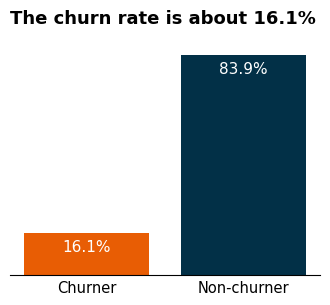

In [19]:
# Group the data by churn flag.
churn_grp = train.groupby(['churn_flag'])[['churn_flag']].count().rename(columns={'churn_flag': 'count'}).reset_index()
churn_grp['pct'] = (churn_grp['count'] / churn_grp['count'].sum()) * 100
churn_grp = churn_grp.sort_values(by=['pct'])

# Define the plot.
fig, ax = plt.subplots(figsize=(4, 3))
        
# Plot the barplot.
bars = ax.bar(x=churn_grp['churn_flag'], height=churn_grp['pct'], color=['#e85d04', '#023047'])
        
# Customize the plot.
ax.set_title('The churn rate is about 16.1%', fontweight='bold', fontsize=13, pad=15, loc='left')
ax.set_xlabel('')
ax.set_xticks(ticks=range(2), labels=['Non-churner', 'Churner'], fontsize=10.5)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.invert_xaxis()
        
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(False)

for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.1f}%'.format(height), 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, -10),  
                textcoords="offset points",
                ha='center', va='center',
                fontsize=11, color='white')

The target is imbalanced. 16.1% of the customers are churners. Thus, We need to adopt some strategies in order to deal with this. They are:

- Stratified hold-out and k-fold cross validation to maintain the target proportion on test and validation sets, even for hyperparameter tuning.
- Define different class weights for majority and minority class instances. The idea is to define higher weights to minority class, such that the model will be penalized when mistakenly classifying a churner customer. These weights are defined on the model specific hyperparameter for it.
- Take a look at precision-recall trade-off if necessary. The main objective here is to predict churn probabilities, not a binary prediction. This will enable the bank to make better informed decisions. Instead of simply assessing if a client will attrit or not, it can check how likely he is to skip the service.

### Numerical features distributions

In [20]:
numplots_features = ['customer_age', 
                     'months_on_book', 
                     'credit_limit', 
                     'total_revolving_bal', 
                     'avg_open_to_buy', 
                     'total_amt_chng_q4_q1', 
                     'total_trans_amt', 
                     'total_trans_ct', 
                     'total_ct_chng_q4_q1', 
                     'avg_utilization_ratio',
                     'total_relationship_count']

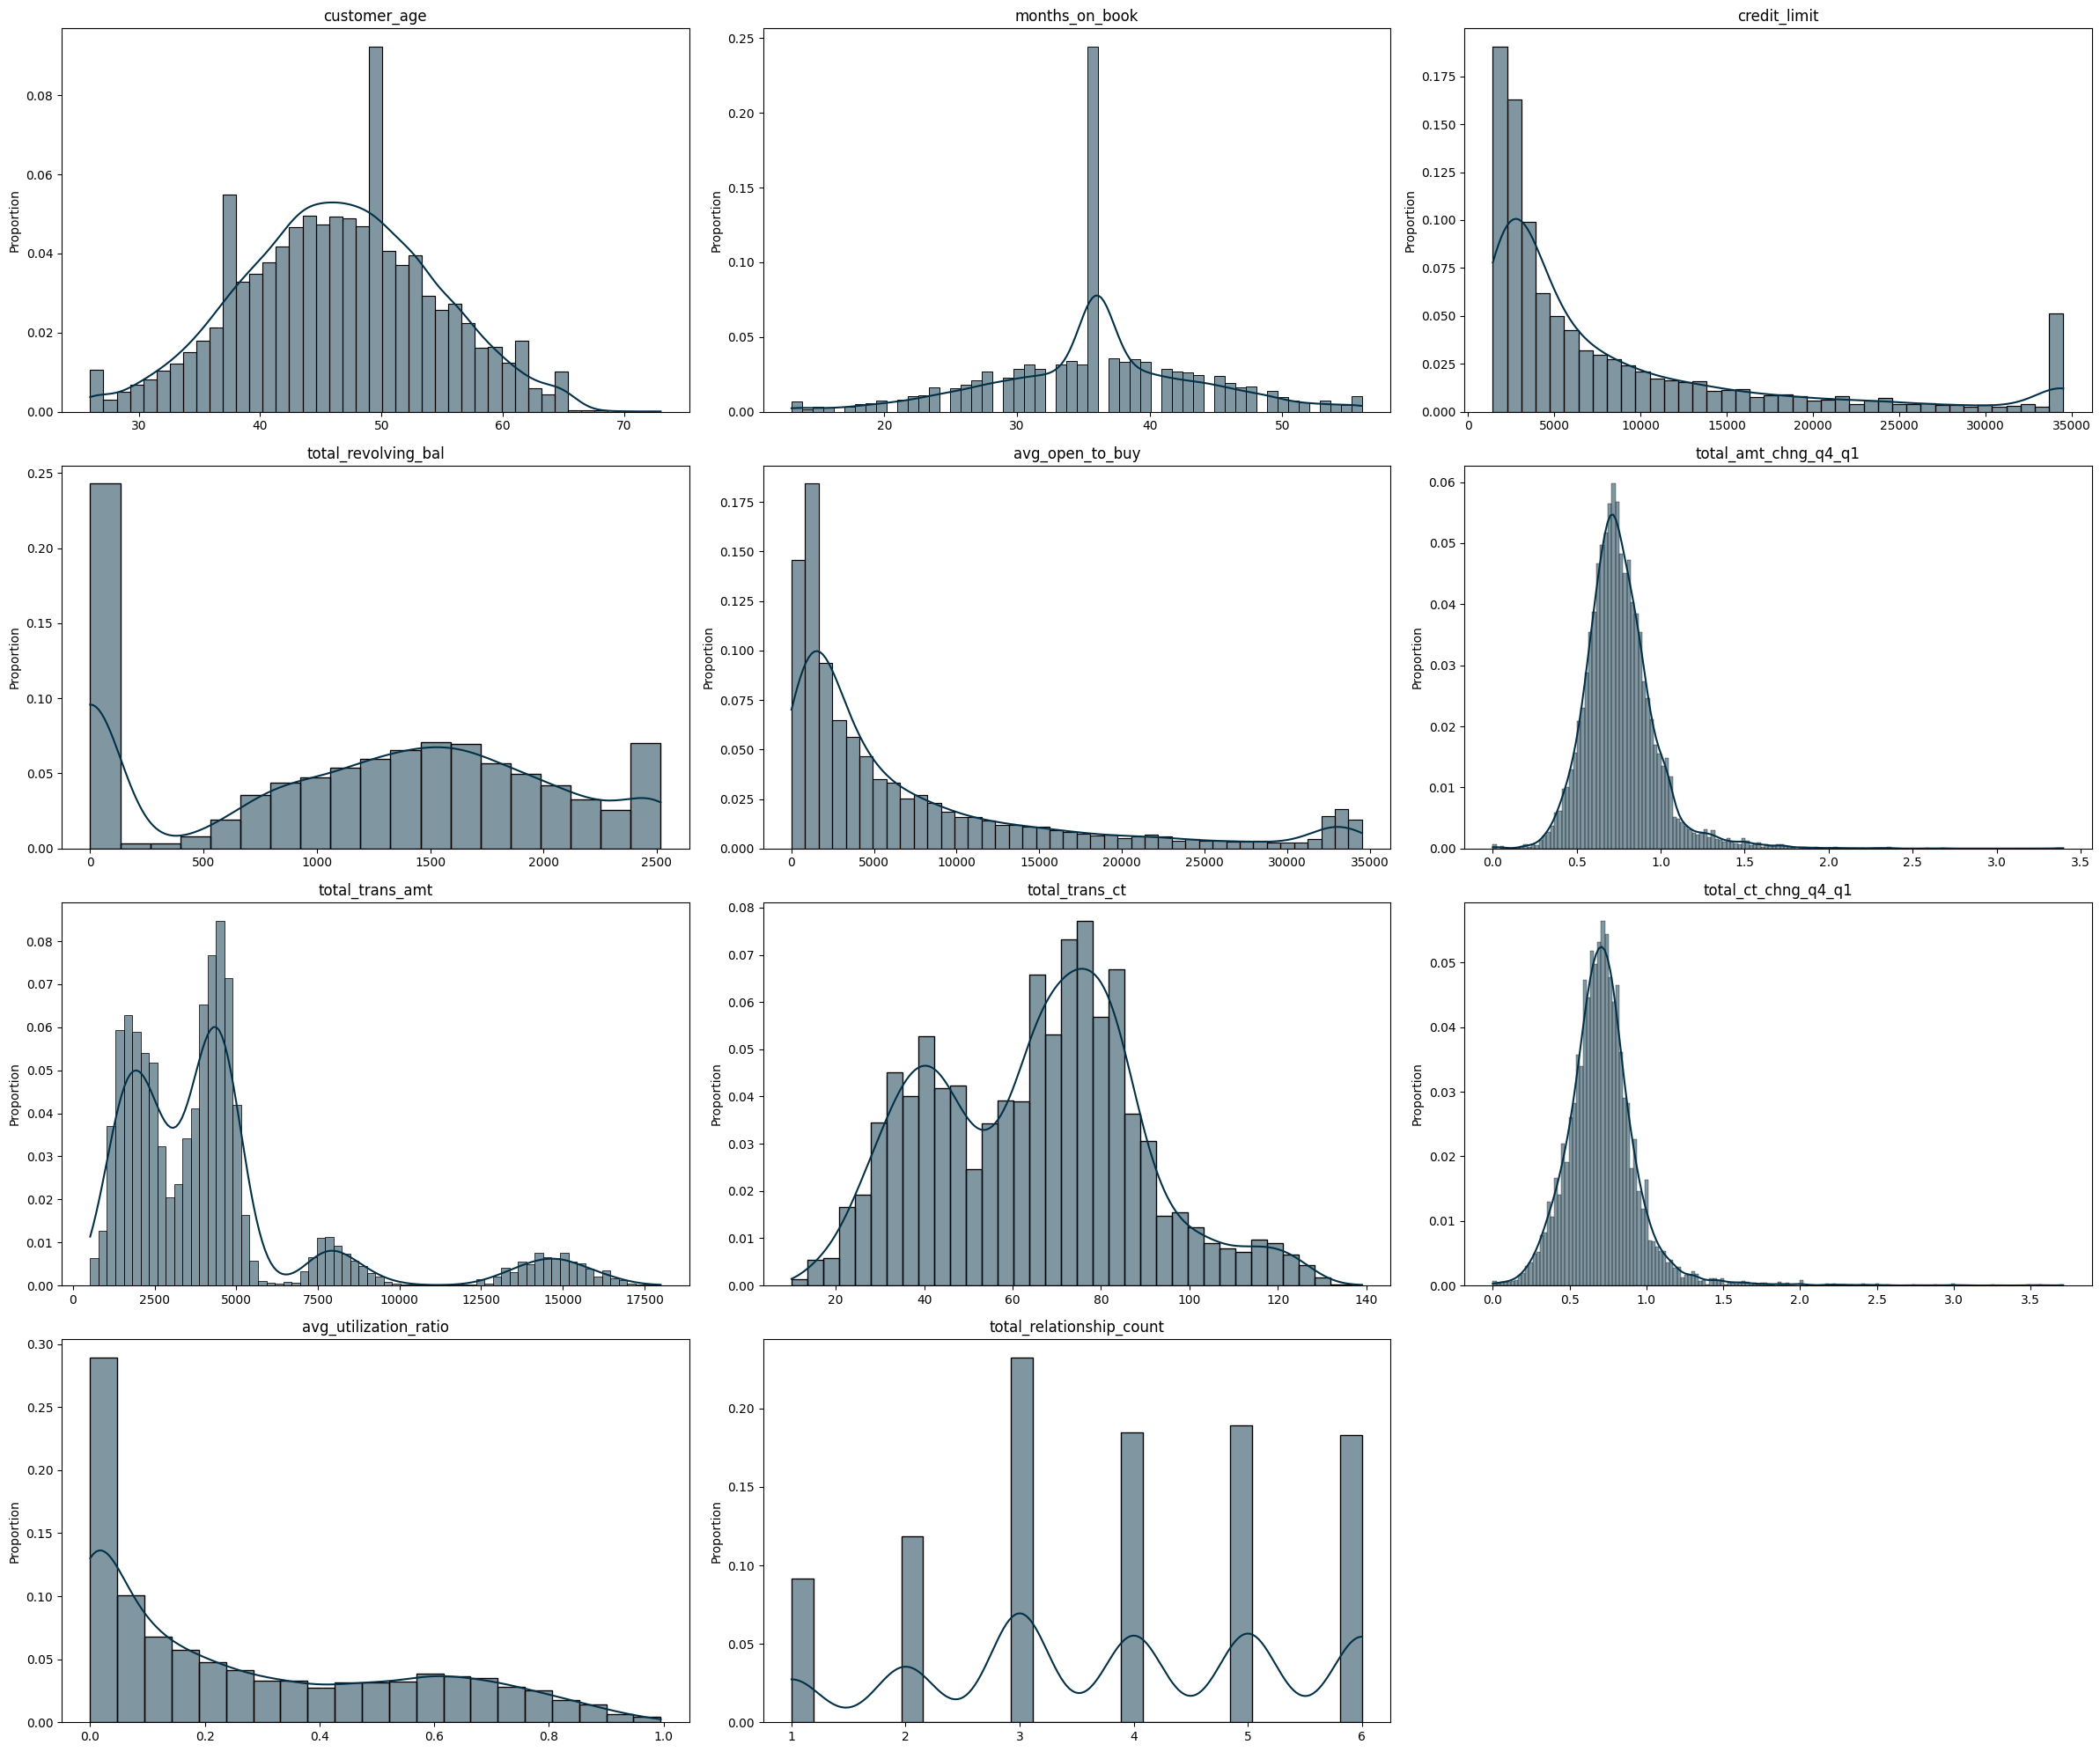

In [25]:
analysis_plots(data=train, features=numplots_features, kde=True, figsize=(24, 20))

Insights:
- Most of the customers are between 40 and 50 years old.
- A large part of the customers spent 36 months consuming the bank's credit card services.
- The credit limit is right-skewed. This means that the majority of customers have low credit limits, while there are relatively few customers with high credit limits. However, it is possible to see that a significant portion of them, about 5%, has a high credit limit, around 35,000. Moreover, both avg_open_to_buy and avg_utilization_ratio are also positively skewed.
- The bank must be alert to the distribution of the average utilization ratio. Being right-skewed means that most customers have a low utilization of the service. Particularly, a large part of them, about 25%, present zero utilization ratio. Therefore, the company must plan strategies to increase utilization and, consequently, revenue.
- A large portion of the customers, also about 25%, have a zero total revolving balance. Lower total revolving balances (specially zero) might indicate a significant likelihood of churn. Considering average utilization ratio and total revolving balance present the same proportion of zero records, these variables might be correlated. I will investigate this further in the analysis.
- Total transaction count and amount distributions seem to have two peaks. There must be a distinction in these distributions with respect to churn flag, which I will investigate further in the analysis. Moreover, a large part of the customers made around 80 or 40 transactions in the last 12 months. Transaction amounts about 5,000 and 2,500 were common.
- About 80% of the customers held at least 3 products of the bank.

### Outliers

In [27]:
outlier_indexes, outlier_counts, total_outliers = check_outliers(data=train, features=numplots_features)

There are 3344 outliers in the dataset.

Number (percentage) of outliers per feature: 

customer_age: 2 (0.02)%
months_on_book: 450 (5.55)%
credit_limit: 784 (9.68)%
total_revolving_bal: 0 (0.0)%
avg_open_to_buy: 775 (9.57)%
total_amt_chng_q4_q1: 311 (3.84)%
total_trans_amt: 704 (8.69)%
total_trans_ct: 1 (0.01)%
total_ct_chng_q4_q1: 317 (3.91)%
avg_utilization_ratio: 0 (0.0)%
total_relationship_count: 0 (0.0)%


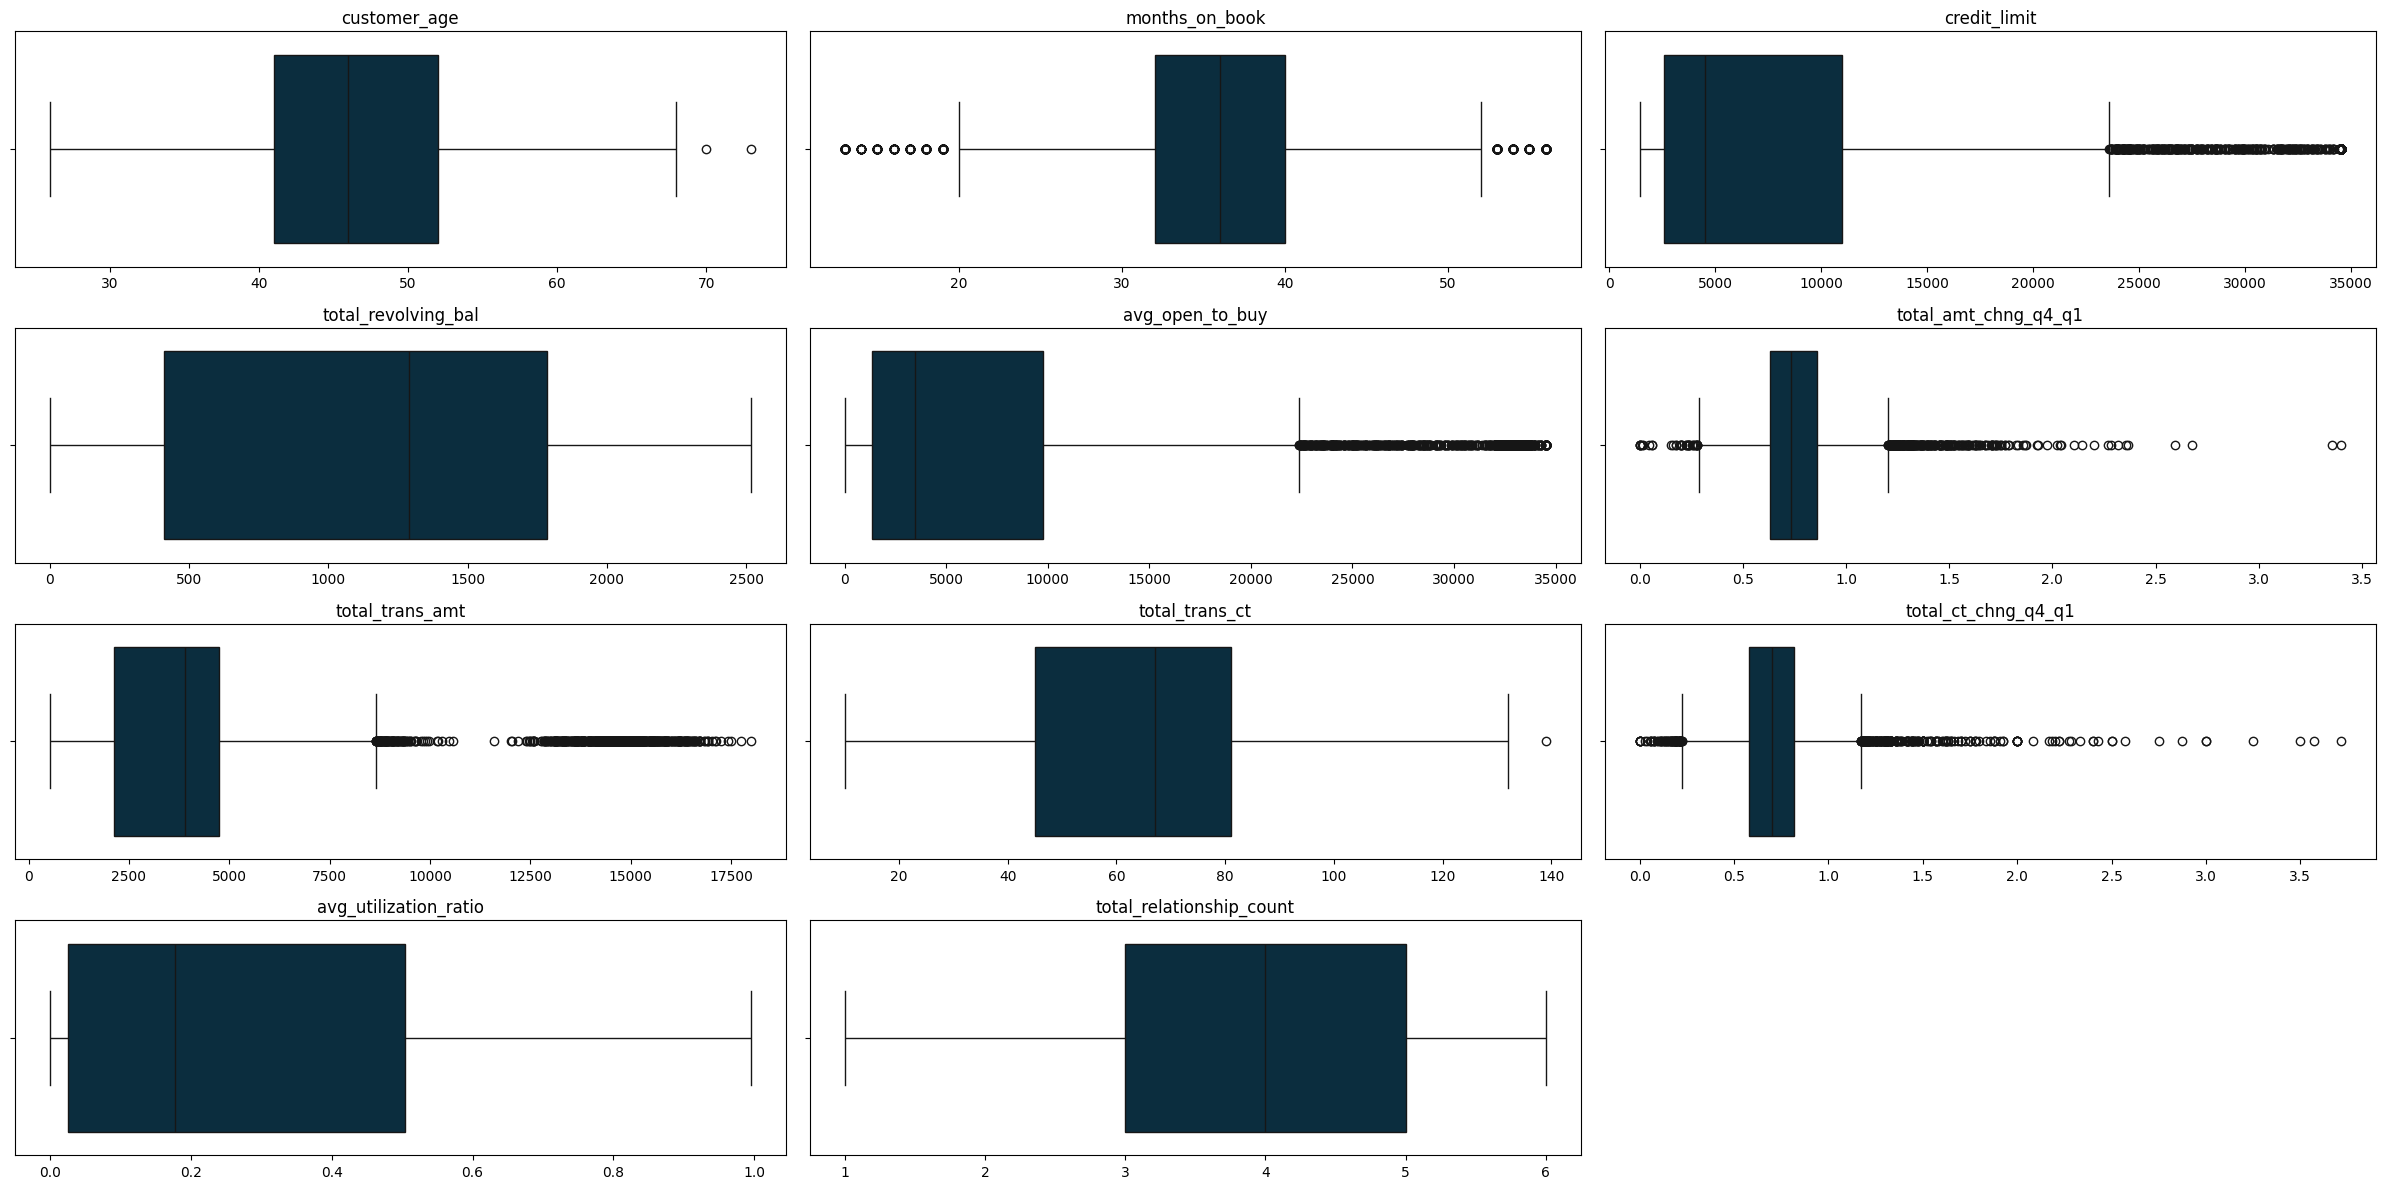

In [28]:
analysis_plots(data=train, features=numplots_features, outliers=True)

### Categorical features distributions

In [29]:
barplot_discrete_features = ['gender', 
                             'dependent_count', 
                             'months_inactive_12_mon', 
                             'contacts_count_12_mon']
barplot_features = barplot_discrete_features + categorical_features

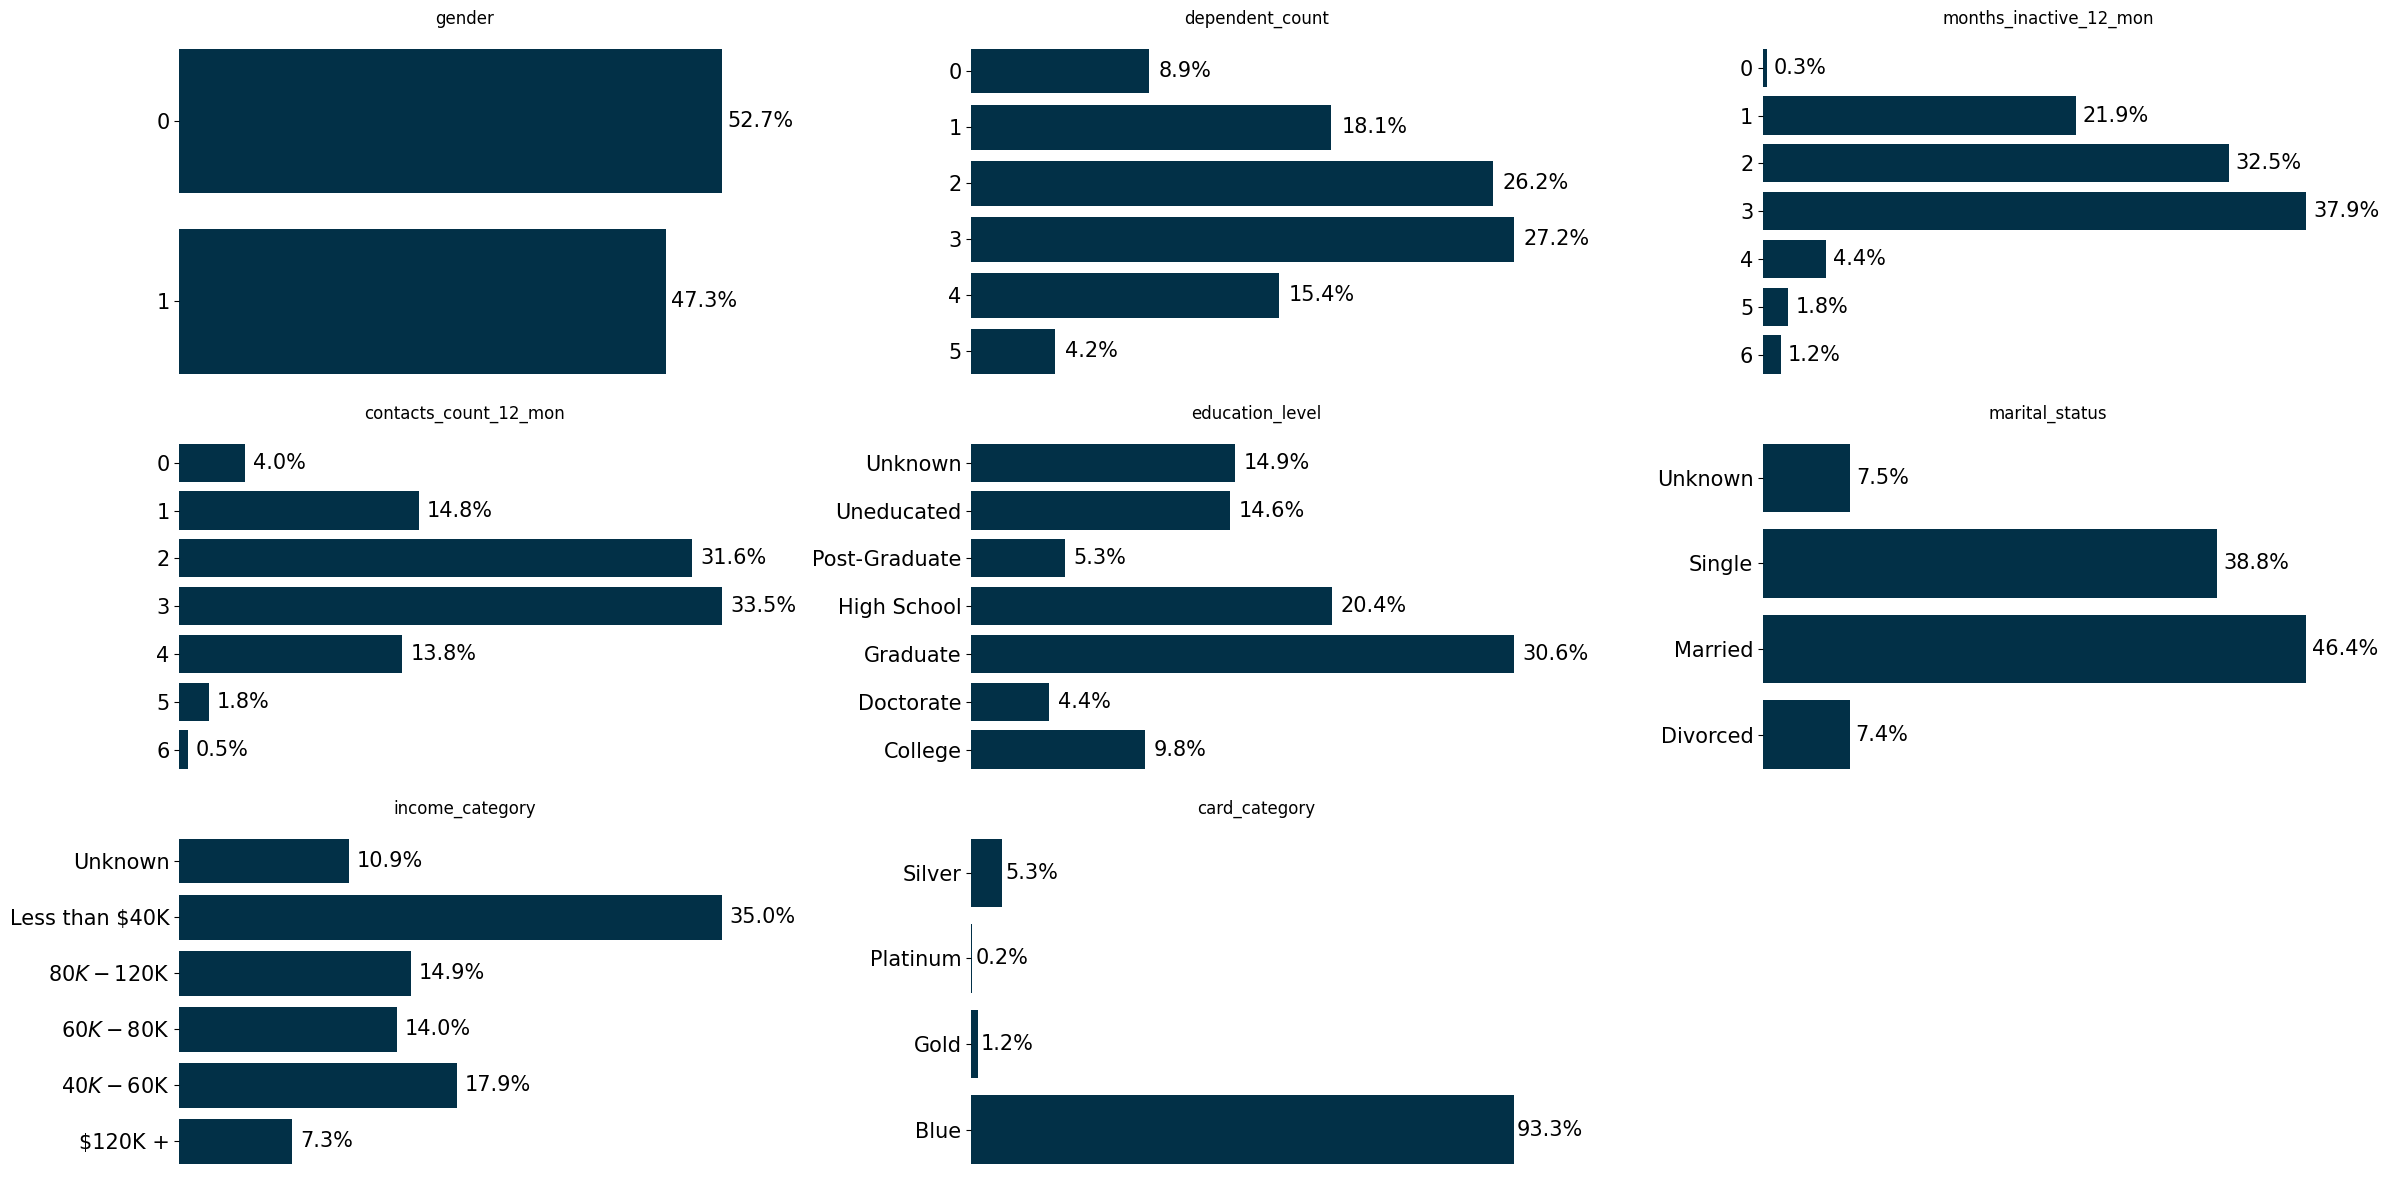

In [30]:
analysis_plots(data=train, features=barplot_features, barplot=True, figsize=(24, 12))

Insights:
- Almost 53% of the customers are female.
- More than 50% of the customers have 2 or 3 dependents.
- 90% of the customers were inactive from 1 to 3 months in the last year. The bank must plan strategies not only to increase the utilization ratio, but also to avoid customer inactivity.
- Most of the customers (approximately 65% of them) contacted the bank 2 or 3 times in the last 12 months. 
- Most of the customers are married or single, graduate, make less than $40K and hold a blue credit card.
- There are some categories with extremely low proportions of observations, like 0 months inactive and 6 contacts count in the last 12 months. Moreover, card category is highly imbalanced, with almost 99% of the customers having blue or silver types. Particularly, blue corresponds to 93.3% of the observations. This will be taken into account in the modeling step. Leaving categories with extremely low proportions of observations can lead to overfitting and card category may not have discriminatory power.